# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

from pandas.plotting import scatter_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load a sample dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Perform train-test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Visualization

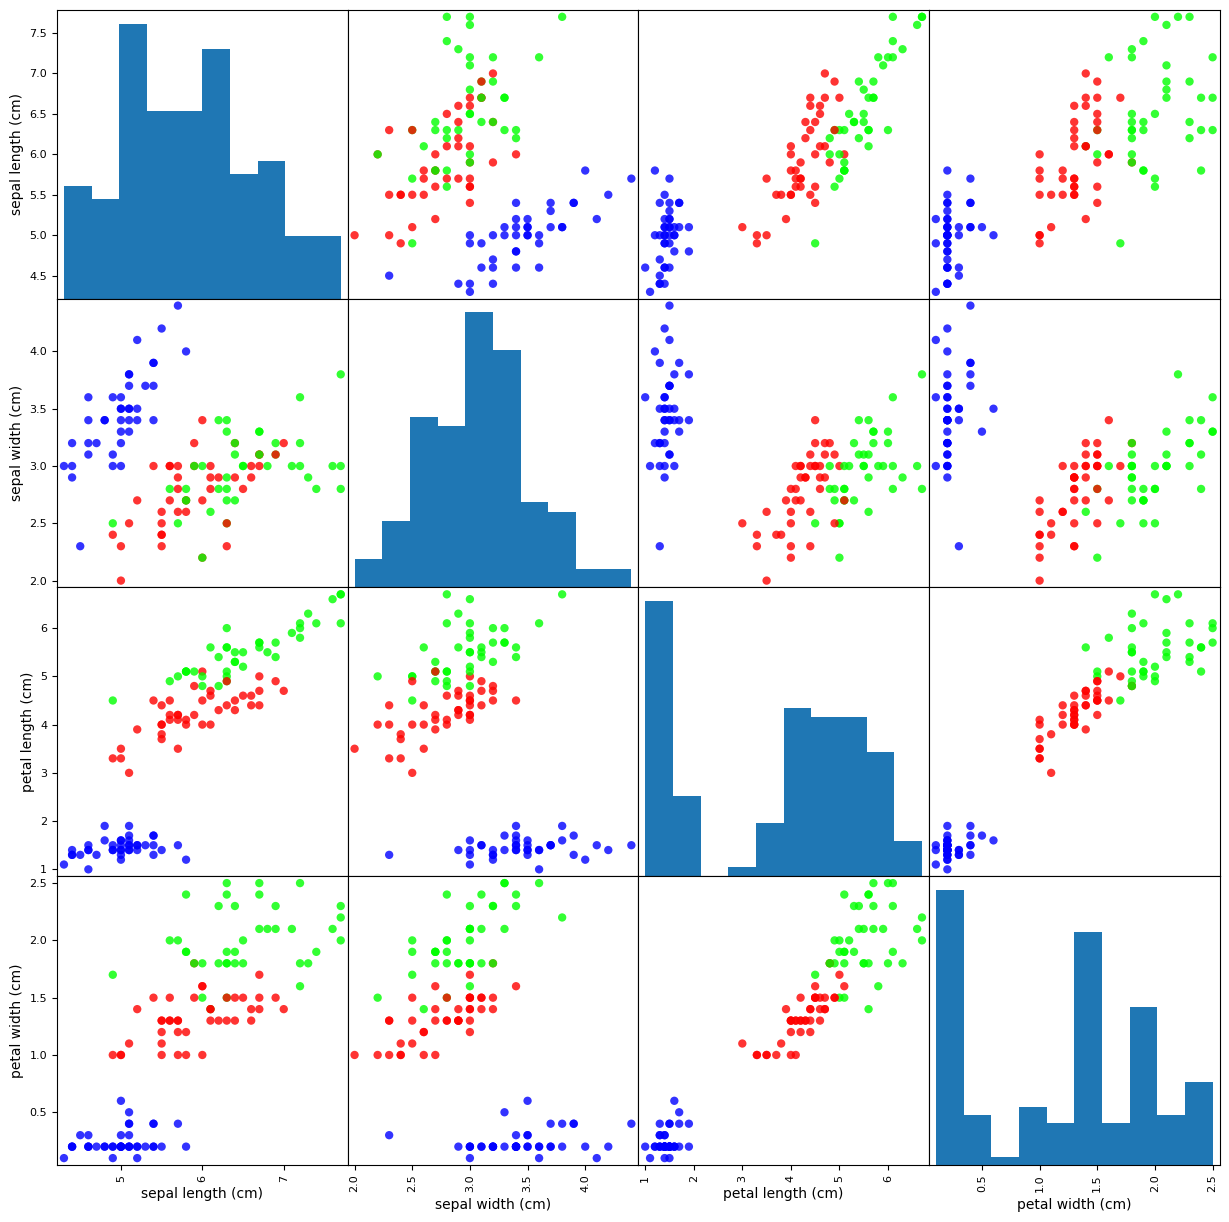

In [4]:
iris_df = pd.DataFrame(X_train, columns=iris.feature_names)

scatter_matrix(iris_df, figsize=(15, 15), diagonal='hist', c=y_train, cmap='brg', marker='o', alpha=0.8)
plt.show()

# Feature Scaling: Standardization

Before training our deep learning model, it's important to ensure that our features are on a similar scale. This is because features with larger scales can disproportionately influence the model's learning process, potentially leading to suboptimal performance.

Here, we apply standardization, which is a common feature scaling technique. Standardization transforms our data to have a mean of zero and a standard deviation of one. The formula for standardization is:

$$z = \frac{(x - \mu)}{\sigma}$$

Where:
- $x$ is the original value.
- $\mu$ is the mean of the feature values.
- $\sigma$ is the standard deviation of the feature values.
- $z$ is the standardized value.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The `fit_transform` method is used on the training data (`X_train`) to compute the mean and standard deviation, which are then used to scale the training data. The `transform` method, applied to the test data (`X_test`), uses these same parameters to scale the test data. This approach prevents any information about the distribution of the test set from influencing the model and ensures that the transformation applied is consistent with the model's training environment.

# Defining Models in Keras: 3 Approaches

## 1. **Sequential API**: 
A straightforward, linear stack of layers suitable for most simple architectures.

In [6]:
def build_sequential_model(input_shape, n_units=64, dropout_rate=0, num_classes=3):
    model = Sequential([
        Dense(n_units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(n_units, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

## 2. **Functional API**: 
A more flexible approach that allows models with non-linear topology, shared layers, and multiple inputs or outputs.

In [7]:
def build_functional_model(input_shape, n_units=64, dropout_rate=0, num_classes=3):
    inputs = tf.keras.Input(shape=input_shape)
    x = Dense(n_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(n_units, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## 3. **Model Subclassing**: 
The most flexible method of model creation that allows for defining custom layers, custom training loops, and more by subclassing the `Model` class.

In [8]:
class CustomModel(Model):
    def __init__(self, input_shape, n_units=64, dropout_rate=0, num_classes=3):
        super(CustomModel, self).__init__()
        self.dense1 = Dense(n_units, activation='relu', input_shape=input_shape)
        self.dropout = Dropout(dropout_rate)
        self.dense2 = Dense(n_units, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        x = self.dense2(x)
        return self.dense3(x)

# Matching Loss Functions with Activation Functions for Different Problems

#### Loss Functions and Activation Functions in Neural Networks

- **Binary Classification**
  - *Last Layer Activation*: `sigmoid`
  - *Loss Function*: `binary_crossentropy`
  
  This setup is used when there are only two classes. The `sigmoid` activation function outputs a value between 0 and 1, representing the probability of the sample belonging to the positive class. The `binary_crossentropy` loss measures the distance between the probability distribution output by the model and the true distribution of the labels.

- **Multi-Class Classification**
  - *Last Layer Activation*: `softmax`
  - *Loss Function*: `sparse_categorical_crossentropy` or `categorical_crossentropy`
  
  For problems where an instance can belong to exactly one of many classes, the `softmax` function is used, which outputs a probability distribution over the classes. If the target classes are one-hot encoded, use `categorical_crossentropy`; if they are integers, `sparse_categorical_crossentropy` is the appropriate choice.

- **Multi-Label Classification**
  - *Last Layer Activation*: `sigmoid`
  - *Loss Function*: `binary_crossentropy`
  
  When each sample can belong to multiple classes, `sigmoid` is used for each output neuron, each representing a binary classification problem. The `binary_crossentropy` loss is calculated for each label.

- **Regression**
  - *Last Layer Activation*: None (linear)
  - *Loss Function*: `mean_squared_error` or `mean_absolute_error`
  
  For regression problems, where the goal is to predict continuous values, no activation function is used (or a linear activation is implied). The `mean_squared_error` loss is commonly used and is particularly sensitive to outliers, while `mean_absolute_error` gives equal weighting to all errors.


# First Attempt at Model Training – Unveiling Overfitting

## Building the Model

In [9]:
model = build_functional_model((X_train_scaled.shape[1],), n_units=512, dropout_rate=0,)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 512)               2560      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 266,755
Trainable params: 266,755
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [12]:
history = model.fit(X_train_scaled, y_train,
                        epochs=50,
                        validation_split=0.2,
                        verbose=1)

Epoch 1/50
3/3 [==============================] - 2s 105ms/step - loss: 0.9537 - accuracy: 0.5417 - val_loss: 0.7020 - val_accuracy: 0.8750
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 0.5894 - accuracy: 0.8125 - val_loss: 0.4971 - val_accuracy: 0.8750
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: 0.4377 - accuracy: 0.8021 - val_loss: 0.4047 - val_accuracy: 0.8750
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3660 - accuracy: 0.8229 - val_loss: 0.3560 - val_accuracy: 0.9167
Epoch 5/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3247 - accuracy: 0.8229 - val_loss: 0.3252 - val_accuracy: 0.9167
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2952 - accuracy: 0.8333 - val_loss: 0.3020 - val_accuracy: 0.9167
Epoch 7/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2699 - accuracy: 0.8646 - val_loss: 0.3031 - val_accuracy: 0.9583
Epoch 8/50
3/3 [==========

## Plotting the training history

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    metrics = [('accuracy', 'Accuracy'), ('loss', 'Loss')]
    epoch_range = len(history.history['loss'])
    plt.figure(figsize=(12, 5))

    for i, (metric, title) in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.plot(history.history[metric], label=f'Training {title}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {title}')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(title)
        plt.legend()

    plt.show()


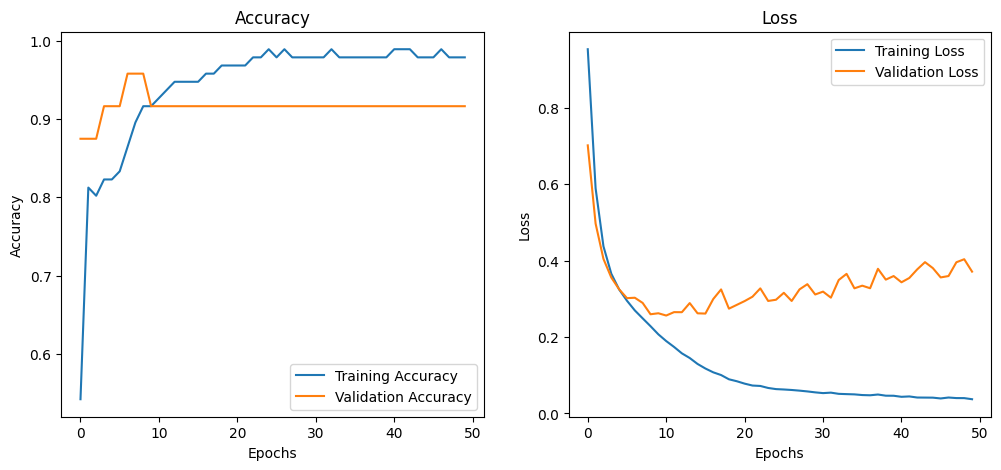

In [14]:
plot_history(history)

# Strategies to Counter Overfitting in Deep Learning

Overfitting is a common problem in machine learning, where a model performs well on the training data but poorly on unseen data due to capturing noise and fluctuations in the training data rather than the underlying data distribution. There are several strategies to counter overfitting:

1. **Gather More Data**
   - More data can help the model to generalize better. With a larger dataset, the model has more examples to learn from, which can dilute the noise and outliers in the data.

2. **Use a Simpler Model**
   - A model with fewer parameters is less likely to overfit. This can be achieved by choosing simpler algorithms, reducing the number of layers in neural networks, or using fewer neurons per layer.

3. **Apply Regularization**
   - Regularization techniques generally add a penalty for model complexity to the loss function, discouraging the model from fitting the training data too closely.
     - *L1 Regularization (Lasso)*: Adds a penalty equal to the absolute value of the magnitude of coefficients, encouraging sparsity in the model parameters.
     - *L2 Regularization (Ridge)*: Adds a penalty equal to the square of the magnitude of coefficients, encouraging smaller and more diffuse parameter values.
     - *Dropout*: In neural networks, dropout randomly sets a fraction of input units to 0 at each update during training time, which helps prevent over-reliance on particular features.

4. **Implement Model Checkpoints and Early Stopping**
   - These techniques involve saving the model at the point when it performs best on a validation dataset, often monitored through a performance metric.
     - *Model Checkpoints*: Save the model periodically during training if it outperforms previous versions on the validation set.
     - *Early Stopping*: Monitor the model's performance on a validation set and stop training when the performance on the validation set starts to degrade.

By combining these strategies, we can increase the likelihood of training a model that generalizes well to new data and avoids overfitting.

# Refined Model Training – Mitigating Overfitting

## Building the Model

In [15]:
model = build_functional_model((X_train_scaled.shape[1],), n_units=128, dropout_rate=0.5,)

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 128)               640       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,539
Trainable params: 17,539
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [18]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [19]:
history = model.fit(X_train_scaled, y_train,
                        epochs=100,
                        validation_split=0.2,
                        callbacks=[early_stopping_callback],
                        verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 86ms/step - loss: 1.0000 - accuracy: 0.5208 - val_loss: 0.9120 - val_accuracy: 0.7083
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.8550 - accuracy: 0.6979 - val_loss: 0.8078 - val_accuracy: 0.7917
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.7679 - accuracy: 0.7188 - val_loss: 0.7172 - val_accuracy: 0.7917
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6682 - accuracy: 0.7708 - val_loss: 0.6386 - val_accuracy: 0.8333
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6017 - accuracy: 0.8125 - val_loss: 0.5730 - val_accuracy: 0.8750
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.5377 - accuracy: 0.8021 - val_loss: 0.5202 - val_accuracy: 0.8750
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4979 - accuracy: 0.8125 - val_loss: 0.4775 - val_accuracy: 0.8750
Epoch 8/100
3/3 [===

## Plotting the training history

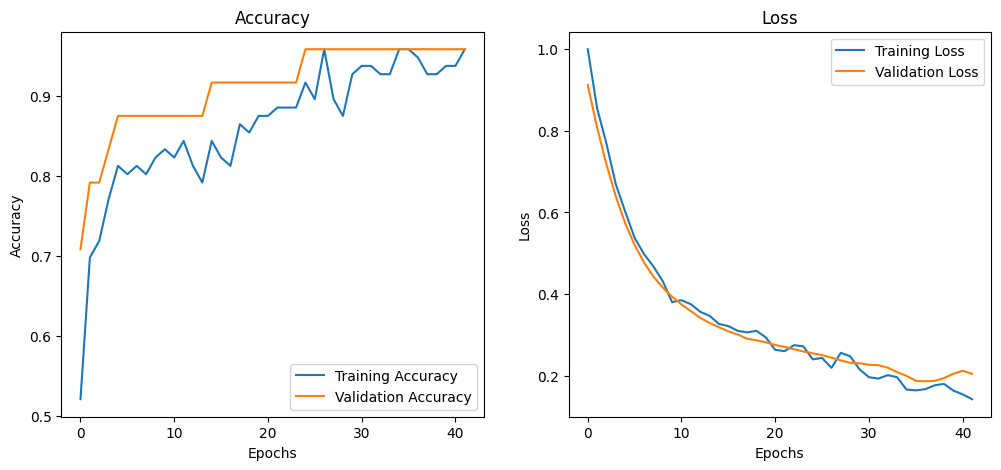

In [20]:
plot_history(history)

# Final Model Training with Full Dataset

In [21]:
model = build_functional_model((X_train_scaled.shape[1],), n_units=128, dropout_rate=0.5,)

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit(X_train_scaled, y_train,
          epochs=37,
          callbacks=[early_stopping_callback],
          verbose=1)

Epoch 1/37
4/4 [==============================] - 1s 4ms/step - loss: 1.0499 - accuracy: 0.5083
Epoch 2/37
4/4 [==============================] - 0s 4ms/step - loss: 0.8654 - accuracy: 0.7917
Epoch 3/37
4/4 [==============================] - 0s 4ms/step - loss: 0.7200 - accuracy: 0.7917
Epoch 4/37
4/4 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.8167
Epoch 5/37
4/4 [==============================] - 0s 4ms/step - loss: 0.5423 - accuracy: 0.8167
Epoch 6/37
4/4 [==============================] - 0s 4ms/step - loss: 0.4992 - accuracy: 0.8333
Epoch 7/37
4/4 [==============================] - 0s 4ms/step - loss: 0.4394 - accuracy: 0.8167
Epoch 8/37
4/4 [==============================] - 0s 4ms/step - loss: 0.4060 - accuracy: 0.8167
Epoch 9/37
4/4 [==============================] - 0s 4ms/step - loss: 0.3982 - accuracy: 0.8167
Epoch 10/37
4/4 [==============================] - 0s 3ms/step - loss: 0.3798 - accuracy: 0.8417
Epoch 11/37
4/4 [======================

# Evaluate the Final Model

In [24]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.0781, Accuracy: 1.0000
